## はじめに：事前準備

### 使用するコードたちをgithubからclone

In [2]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 406 (delta 3), reused 5 (delta 2), pack-reused 397
Receiving objects: 100% (406/406), 7.91 MiB | 37.16 MiB/s, done.
Resolving deltas: 100% (230/230), done.


### 色々データがあるところに移動

In [57]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


# 2章 自然言語と単語の分散表現

「単語の意味」をコンピュータに理解させるためには？

「単語の意味」を表現する手法

*   シソーラス
*   カウントベース


## シソーラス

シソーラスとは類語辞書であり、「同じ意味の単語(同義語)」や「意味の似た単語(類義語)」が同じグループに分類されています。

同義語の例：car、auto、sutomobileなどは、「自動車」を表す同義語

自然言語処理において利用されるシソーラスは、「上位と下位」「全体と部分」などの、より細かい関連性が定義されていることがある。

シソーラスは人の手によるラベル付けをしている。欠点がいくつかある。

*   時代の変化に対応するのが困難 (新語が作られていく)
*   人の作業コストが高い
*   単語の細かなニュアンスを表現できない (「ヴィンテージ」と「レトロ」)



### WordNet

自然言語処理の分野において、もっとも有名なシソーラス。動かしてみる。

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

「car」の同義語をWordNetで取得してみる。

In [ ]:
wordnet.synsets('car')

carには5つの異なる同義語グループが存在するということ。

car.n.01 は carという名詞(noun)の1番目 ということ。

car.n.01とcar.n.02 それぞれの見出し語で指定される同義語の意味を確認してみる

In [ ]:
car = wordnet.synset('car.n.01')
car.definition()

In [ ]:
car2 = wordnet.synset('car.n.02')
car2.definition()

同義語グループの中身を見てみる


In [ ]:
car.lemma_names()

In [ ]:
car2.lemma_names()

「car」の単語ネットワークを使って、ほかの単語との上位・下位の関係性を見てみる。

In [ ]:
car.hypernym_paths()[0]

単語間の類似度を求めることも可能

In [36]:
car = wordnet.synset('car.n.01')
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')

In [ ]:
car.path_similarity(novel)

In [ ]:
car.path_similarity(dog)

In [ ]:
car.path_similarity(motorcycle)

## カウントベースによる手法

コーパスを利用する。

自然言語処理の研究やアプリケーションのために目的をもって収集されたテキストデータを、一般的に「コーパス」と呼ぶ。

コーパスによっては、テキストデータの個々の単語に対して「品詞」がラベル付けしていたりする。

### コーパスの下準備

まずは1文からなる単純なテキストコーパスを使用する。

In [ ]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.',' .')
text

In [ ]:
words = text.split(' ')
words

単語に分割されました。

しかし、テキストのまま扱うのは不便なので、単語にIDを振って、IDのリストとしてできるように手を加える。

In [58]:
word_to_id = {}
id_to_word = {}

for word in words:
  if word not in word_to_id:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [59]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [60]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [61]:
id_to_word[1]

'say'

In [62]:
word_to_id['hello']

5

単語のリスト⇒単語のIDのリスト を行う。NumPy配列に変換する。

In [63]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

下準備以上！

これらの作業をまとめたものをpreprocess()という名前の関数にする。(deep-learning-from-scratch-2/common/util.py)

In [5]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [6]:
from common.util import preprocess
text = 'You say hello and I say goodbye.'
corpus, word_to_id, id_to_word = preprocess(text)

In [7]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

この手法によって、単語をベクトルで表すことが可能になる。

### 単語の分散表現

世の中には様々な「色」がある。

正確に色を指定するために、RGB(Red/Green/Blue)のようなベクトル表現が用いられている。(3次元のベクトル)

例えば、「深緋(こきあけ)」という名前がわからなくても、(R,G,B)=(201,23,30)といわれれば、なんとなく色が思いつく。(赤っぽい？)

色同士の関連(似た色かどうか)もベクトル表現の方がわかりやすい。

「色」のベクトル表現みたいなことを、「単語」にも行いたい！

「単語の意味」を的確にとらえたベクトル表現が目標。これを自然言語処理の分野で、単語の分散表現という。

### 分布仮説

単語をベクトルで表す研究は数多く行われているが、重要な手法のほとんどが、とあるシンプルなアイデアに基づいている。

**「単語の意味は、周囲の単語によって形成される」**

単語自体に意味はなく、その単語の「コンテキスト(文脈)」によって、単語の意味が形成される。

*   「I drink beer.」「We drink beer.」  drinkの近くには飲み物が表れやすい？
*   「I guzzle beer.」「We guzzle wine.」  guzzleはdrinkみたいな意味？

これからいう「コンテキスト」は、注目する単語の周囲にある単語のことをさす。

コンテキストのサイズ(周囲何単語含めるか)を、ウィンドウサイズという言葉で表す。

例)「goodbye」に注目したとき、ウィンドウサイズが２の「コンテキスト」

**you say** goodbye **and i** say hello

### 共起行列

分布仮説に基づいて、単語をベクトルで表す方法を考える。

ある単語に注目したとき、その周囲にどのような単語がどれだけ現れるかをカウントし、集計する。

ここでは、これを「カウントベースの手法」と呼ぶ。(文献によっては「統計的手法」と言ったりする)

実際にカウントベースの手法を見てみましょう。

まず、テキストの下準備からスタート。

In [2]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [6]:
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


単語数は8つだけど、語彙数が全部で7つあることがわかる。

今回はウィンドウサイズを１にして、コンテキストに含まれる単語の頻度を数える。

例) you say goodbye and i say hello .

you に注目したとき：you **say** goodbye and i say hello . → [0, 1, 0, 0, 0, 0, 0]

say に注目したとき：**you** say **goodbye** and **i** say **hello** . → [1, 0, 1, 0, 1, 1, 0]

(配列のそれぞれの要素は、[ 'you', 'say', 'goodbye', 'and', 'i', 'hello', '.' ])

これを全ての単語(7つ)に行う。

create_co_matrix(corpus, vocab_size, window_size=1) という関数名で実装。(deep-learning-from-scratch-2/common/util.py)

In [8]:
len(word_to_id)

7

In [9]:
from common.util import create_co_matrix

create_co_matrix(corpus,len(id_to_word),window_size=1)

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

各行が、それぞれの単語に対応している。この行列を、**共起行列**という。

### ベクトル間の類似度

ベクトル間の類似度を計測するための手法はいろいろ。(ベクトルの内積とかユークリッド距離とか)

単語のベクトル表現の類似度に関しては、**コサイン類似度**がよく用いられる。

$$
  similarity(𝐱,𝐲)=\frac{𝐱⋅𝐲}{||𝐱||\,||𝐲||}=\frac{x_1y_1+\cdots+x_ny_n}{\sqrt{x_1^2+\cdots+x_n^2}\sqrt{y_1^2+\cdots+y_n^2}}
$$

直感的には、「二つのベクトルがどれだけ同じ方向を向いているか」を指している。

完全に同じ向きだったら類似度は１、完全に逆向きだったら－１

コサイン類似度の実装(deep-learning-from-scratch-2/common/util.py)

コサイン類似度を試してみる(deep-learning-from-scratch-2/ch02/similarity.py)

In [14]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [12]:
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  #「you」の単語ベクトル
c1 = C[word_to_id['i']]  #「i」の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067691154799


### 類似単語のランキング表示

ある単語がクエリとして与えられたとき、そのクエリに対して類似した単語を上位から順に表示する関数most_similar()を実装。

(deep-learning-from-scratch-2/common/util.py)

most_similar(query, word_to_id, id_to_word, word_matrix, top=5)

*   query：単語
*   word_to_id：単語⇒単語IDの辞書
*   id_to_word：単語ID⇒単語の辞書
*   word_matrix：単語ベクトルをまとめた行列
*   top：上位何件まで表示するか



ランキング表示してみる ( deep-learning-from-scratch-2/ch02/most_similar.py )

In [15]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [16]:
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## カウントベースの手法の改善 (そこまで重要じゃない)

### 相互情報量

例えば、「... the car ...」というフレーズを考える。

結構セットで出てくる！でも「the」と「car」は意味的には近くない！

今までのままだと「car」は頻繁に登場する「the」と強い関連性を持ってしまう。(「drive」とかの単語との関連性を強くしたい)

ここで、**相互情報量**(Pointwise Mutual Information)と呼ばれる指標を使う。

単語の出てくる頻度も計算に入れる。

$$
  PMI(x,y)=\log_2 \frac{C(x,y)\cdot N}{C(x)\,C(y)}
$$


*   N：コーパスに含まれる単語数
*   C(x)：単語xの出現回数
*   C(x,y)：単語xとyの共起回数


例えば、

*   N=10,000
*   C('the')=1,000
*   C('car')=20
*   C('drive')=10
*   C('the','car')=10
*   C('car','drive')=5



$$
  PMI('the','car')=\log_2 \frac{10\cdot 10000}{1000\cdot20}\approx2.32
$$

$$
  PMI('car','drive')=\log_2 \frac{5\cdot 10000}{20\cdot10}\approx7.97
$$

しかし、共起回数が0になってしまうと、PMIが－∞になってしまう。

そのため、正の相互情報量(Positive PMI)が使われます。

$$
  PPMI(x,y)=max(0,PMI(x,y))
$$

共起行列をPPMI行列に変換してみる。
( deep-learning-from-scratch-2/ch02/ppmi.py )

In [17]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [18]:
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 次元削減

実際のコーパスはもっと長くなる。

つまり、次元数も増えまくる。

重要な情報をできるだけ残して削減しよう！ ⇒ **特異値分解** (Singular Value Decomposition:SVD)

SVDしてみる。( deep-learning-from-scratch-2/ch02/count_method_small.py )

In [19]:
%cd /content/deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


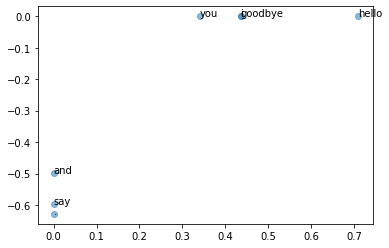

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print(C[0])
print(W[0])
print(U[0])

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### PTBデータセット

でっけえコーパス

In [21]:
%cd /content/deep-learning-from-scratch-2/ch02

/content/deep-learning-from-scratch-2/ch02


In [22]:
!python3 show_ptb.py

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


カウントベースの手法を試してみる

In [23]:
%cd /content/deep-learning-from-scratch-2/ch02

/content/deep-learning-from-scratch-2/ch02


In [25]:
!pip install sklearn

In [26]:
!python3 count_method_big.py

counting  co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.

# 3章 word2vec

単語の分散表現を得る手法として「推論ベースの手法」を紹介する。

## 推論ベースの手法とニューラルネットワーク

### カウントベースの問題点

コーパスで扱う語彙数は超巨大。

もし語彙数が100万ならば100万×100万の行列を作ることになる。

SVDを行うのは現実的じゃない。

また、カウントベースは学習データを一度にまとめて処理する。


一方、推論ベースはニューラルネットを用いる。

ニューラルネットによる学習は、データを小分けにして処理(ミニバッチ)できる。

さらに、複数マシン・複数GPUの利用による並列計算も可能で、全体学習の高速化も可能。


### 推論ベースの手法の概要

図を挿入するのが大変なので、qiitaの記事を使って紹介します。

[Word2Vecを理解する](https://qiita.com/g-k/items/69afa87c73654af49d36)

## CBOWモデルの実装

### コンテキストとターゲット

In [3]:
%cd /content/deep-learning-from-scratch-2/ch03

/content/deep-learning-from-scratch-2/ch03


いつもの前処理からスタート

In [4]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


単語IDの配列であるcorpusから、contextsとtargetを作る。

corpus : [ 0 1 2 3 4 1 5 6 ] → contexts[0] : [ 0 2 ] , target[0] : 1

コンテキストとターゲットを作成する関数 create_contexts_target (corpus, window_size) を実装。 

( deep-learning-from-scratch-2/common/util.py )

In [7]:
import sys
sys.path.append('..')
from common.util import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


あとは、これをCBOWモデルに与えるだけ。

各要素は単語IDのままなので、one-hot表現にする。

### one-hot表現への変換

In [8]:
%cd /content/deep-learning-from-scratch-2/ch03

/content/deep-learning-from-scratch-2/ch03


one-hot表現への変換を行う、convert_one_hot()関数を実装。

( deep-learning-from-scratch-2/common/util.py )

In [12]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

print(target)
print('-'*50)
print(contexts)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print('-'*20)
print(target)
print('-'*20)
print(contexts)

[1 2 3 4 1 5]
--------------------------------------------------
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
--------------------
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
--------------------
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


### simpleCBOWモデルの実装

[CBOWモデルの構成](https://camo.qiitausercontent.com/124ffb2149b9d9df3d8c78e5c8efd1994b58767e/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3339353233302f66646464623633352d306363642d343931622d336539632d3237616161613361653533302e706e67)

In [13]:
%cd /content/deep-learning-from-scratch-2/ch03

/content/deep-learning-from-scratch-2/ch03


CBOWモデルの構成を見ながら、SimpleCBOWを実装する。

(deep-learning-from-scratch-2/ch03/simple_cbow.py)

In [ ]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f') ## 32bitの浮動小数点数で初期化
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

forwardの中身 (contexts[:, 0])

In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size) 

print(contexts)
print('-'*20)
print(contexts[:, 0])
print(contexts[:, 1])

### 学習コードの実装

学習データの準備してニューラルネットに与える ⇒ 勾配を求める ⇒ 重みパラメータをアップデート

(deep-learning-from-scratch-2/ch03/train.py)

In [ ]:
%cd /content/deep-learning-from-scratch-2/ch03

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

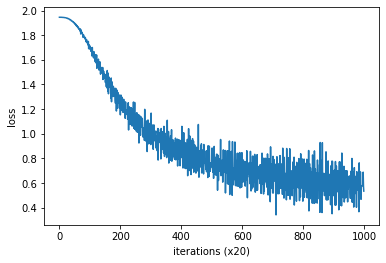

In [17]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [18]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.0659056  1.2571478  1.2279309  1.1820198 -1.0643494]
say [ 1.1748785  -1.2245086  -0.18318285 -1.1777846   1.1894472 ]
goodbye [-0.90467995  0.48826957  0.7984221   0.72020423 -0.85053194]
and [ 0.912122  -1.0635061 -1.8938776 -0.9406491  0.9811404]
i [-0.8831112   0.4945579   0.8129571   0.71967775 -0.82070774]
hello [-1.0545794  1.2793224  1.2177653  1.1905255 -1.0706657]
. [ 1.0883834 -1.0081315  1.7284766 -1.0293487  1.0463433]


単語の分散表現を得ることができた！

# 4章 word2vecの高速化

simpleCBOWモデルは巨大なコーパスを扱う場合

*   入力層のone-hot表現と重み行列W_inの積による計算
*   中間層と重み行列Woutの積およびsoftmaxレイヤの計算

のときに、多くの計算リソースが必要になってしまう。

## Embeddingレイヤ

MutMulレイヤで実装を行ったが、重みパラメータから対応する行ベクトルを取ってくるだけで大丈夫そう。

対応する重みを取り出すレイヤをEmbeddingレイヤとして実装。(common/layers.py)

In [19]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            np.scatter_add(dW, self.idx, dout)
        else:
            np.add.at(dW, self.idx, dout)
        return None

## Negative Sampling (負例サンプリング)

### 多値分類から二値分類へ

[CBOWモデルの構成(巨大ver)](https://kiyosucyberclub.web.fc2.com/ZeroNLP/ZeroNLP_Fig04-01.jpg)

コンテキストが「you」と「goodbye」のときのターゲットとなる単語は何ですか？

↓

コンテキストが「you」と「goodbye」のときのターゲットは「say」ですか？

[二値分類にしたモデル](https://kiyosucyberclub.web.fc2.com/ZeroNLP/ZeroNLP_Fig04-02.jpg)

そのターゲットとなる単語だけスコアを計算する。

スコアを確率に変換するため、シグモイド関数と交差エントロピー誤差を利用する。

[全体](https://kiyosucyberclub.web.fc2.com/ZeroNLP/ZeroNLP_Fig04-03.jpg)

### これだけで解決じゃない

今のところ正例についてしか学習していない。

本当に行いたいことは、正例のときはSigmoidレイヤの出力を1に近づけ、負例のときはSigmoidレイヤの出力を0に近づけること。

でも、全部の負例を対象にしちゃうと語彙数が増えてしんどくなる。

⇒負例を少数サンプリングする

それぞれのデータにおける損失を足し合わせて最終的な損失とする。

[負例サンプリングを用いた構成図](https://kiyosucyberclub.web.fc2.com/ZeroNLP/ZeroNLP_Fig04-04.jpg)

### サンプリング方法

コーパス中でよく使われる単語は抽出されやすくし、あまり出現しないレアな単語は抽出されにくくする。

ランダムにサンプリングするよりいい。

### Negative Sampling の実装

(deep-learning-from-scratch-2/ch04/negative_sampling_layer.py)

In [21]:
%cd /content/deep-learning-from-scratch-2/ch04

/content/deep-learning-from-scratch-2/ch04


In [22]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

## 改良版word2vecの学習

###CBOWモデルの実装

(ch04/cbow.py)

In [20]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOWモデルの学習

(ch04/train.py) (util/layers.pyを少し改変)

**[重要]** ここで、ランタイムをGPUに設定する。

メニューバーから 

ランタイム > ランタイムのタイプを変更 > GPU > 保存

このセルから再開してOK

In [2]:
## deep-learning-from-scratch-2がいなくなっていたら再度clone
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 406 (delta 3), reused 5 (delta 2), pack-reused 397
Receiving objects: 100% (406/406), 7.91 MiB | 36.01 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [3]:
%cd /content/deep-learning-from-scratch-2/ch04

/content/deep-learning-from-scratch-2/ch04


多分このまま学習してもエラーが出る

common/layes.py Embeddingを少し改変

```
#付け足す1
if GPU:
    import cupyx

class Embedding:
・・・
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        if GPU:
            # np.scatter_add(dW, self.idx, dout)  ###コメントアウト
            cupyx.scatter_add(dW, self.idx, dout) ###付けたし部分2
        else:
            np.add.at(dW, self.idx, dout)
        return None
```
また、

ch04/train.py で

```
# config.GPU=True
```
のコメントアウトを消去する


In [10]:
!python3 train.py

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 1 / 9295 | time 2[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 2[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 3[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 3[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 3[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 3[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 3[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 4[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 4[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 4[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 4[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 4[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 4[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 5[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 5[s] | loss 2

### CBOWモデルの評価

2章で作成したmost_similara()メソッドで、いくつかの単語に対して最も距離の近い単語を表示してみる。(ch04/eval.py)

+α analogyタスクが可能！

king - man + woman = queen みたいな感じができる

In [11]:
%cd /content/deep-learning-from-scratch-2/ch04

/content/deep-learning-from-scratch-2/ch04


In [12]:
!python3 eval.py


[query] you
 i: 0.7421875
 we: 0.7333984375
 anything: 0.59716796875
 your: 0.59619140625
 anybody: 0.57470703125

[query] year
 month: 0.8447265625
 summer: 0.7802734375
 spring: 0.771484375
 week: 0.76904296875
 decade: 0.70361328125

[query] car
 window: 0.6279296875
 luxury: 0.5927734375
 truck: 0.58837890625
 cars: 0.580078125
 auto: 0.57666015625

[query] toyota
 seita: 0.68115234375
 honda: 0.64892578125
 marathon: 0.62744140625
 nissan: 0.61962890625
 engines: 0.60205078125
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 4.8125
 mother: 4.484375
 a.m: 4.2734375
 wife: 4.1796875
 downside: 4.1015625

[analogy] take:took = go:?
 came: 4.53125
 eurodollars: 4.49609375
 're: 4.38671875
 went: 4.36328125
 were: 4.234375

[analogy] car:cars = child:?
 a.m: 6.50390625
 rape: 5.5859375
 children: 5.3828125
 incest: 4.6796875
 adults: 4.65234375

[analogy] good:better = bad:?
 rather: 6.07421875
 less: 5.5
 more: 5.44921875
 greater: 4.484375
 f

# 5章・6章 RNN・LSTM

## 理論の復習

[今度こそわかるぞRNN, LSTM編](https://qiita.com/kazukiii/items/df809d6cd5d7d1f57be3)

[ゼロから作るRNNによる文章分類モデル](https://qiita.com/Kosuke-Szk/items/43f330b0888f8e696c3f)

## 実装は次回！